In [1]:
import pandas
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')

In [2]:
dir = "./"
#Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype='object')
#columns to be droped: name

def get_data():

    train_data = pandas.read_csv("train.csv")
    test_data = pandas.read_csv("test.csv")
    other_data = pandas.read_csv("gender_submission.csv")

    return train_data, test_data, other_data

def clean_columns(data = []):

    #general
    for column in data.columns:
        check_nan = data[column].isnull().values.any()
        if check_nan:
            print(column, "-", check_nan)
            #Age, Cabin, Embarked
    data = data.dropna()

    return data

def drop_columns(data, cols = []):
  for col in cols:
    data.drop(col, inplace=True, axis=1)

Data Analysis


In [6]:
train, test, test_res = get_data()
test = test.merge(test_res)

In [9]:
train = clean_columns(train)
test = clean_columns(test)

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [11]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
12,904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23.0,1,0,21228,82.2667,B45,S,1
14,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S,1
24,916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.3750,B57 B59 B63 B66,C,1
26,918,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C,1
28,920,1,"Brady, Mr. John Bertram",male,41.0,0,0,113054,30.5000,A21,S,0


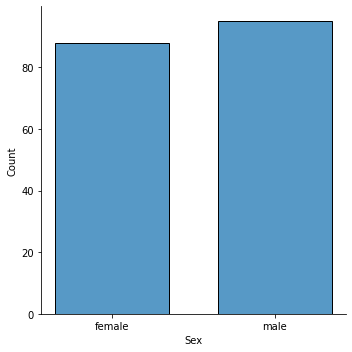

In [12]:
# Distribution of people per sex
sns.displot(train, x="Sex", shrink= 0.7, discrete= True)

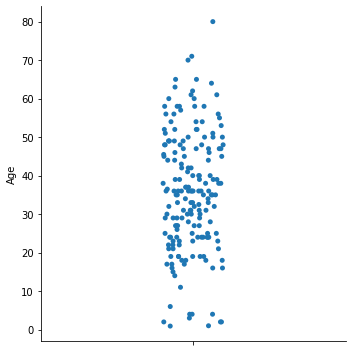

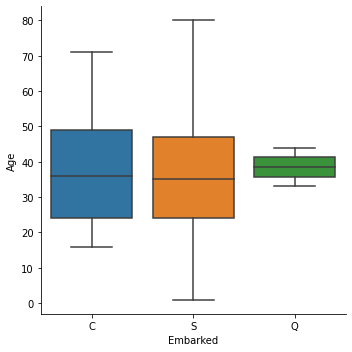

In [13]:
sns.catplot(y="Age", data = train)
sns.catplot(x="Embarked", y = "Age", kind="box", data=train);

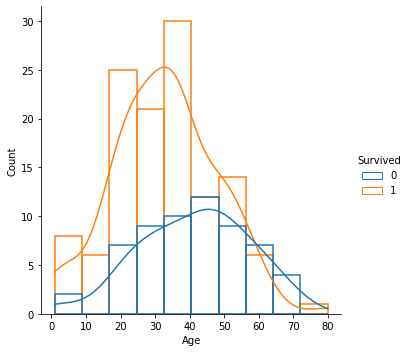

In [14]:
# Distribution of people per age that survived with KDE distribution
sns.displot(train, x="Age", hue = "Survived", kde = True, fill = False)

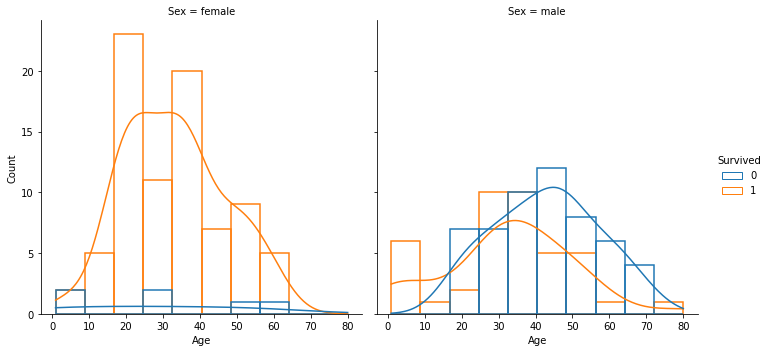

In [15]:
#Distribution of people by sex and if they survived or not
sns.displot(train, x="Age", col="Sex", hue="Survived", kde = True, fill = False)

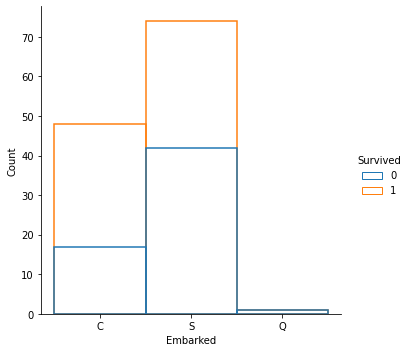

In [16]:
#Distribution of people per age and sex that survived with KDE distribution
sns.displot(data=train, x="Embarked", hue="Survived", fill = False)

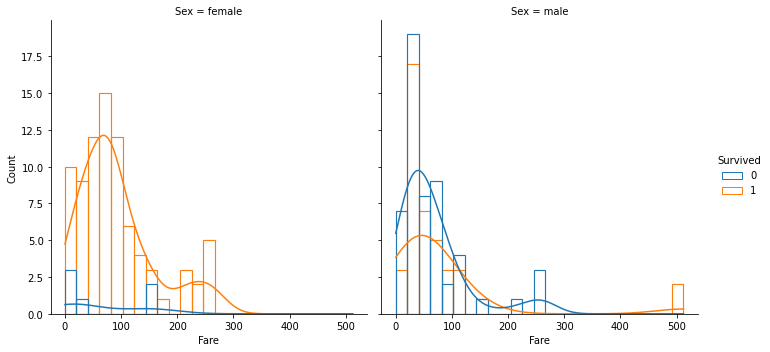

In [17]:
# Distribution of people per age that survived with KDE distribution
sns.displot(train, x="Fare", col = "Sex", hue = "Survived", kde = True, fill = False)

Convert data

In [18]:
def convert_sex_to_binary(data):
  genders = {"male": 1, "female": 2}
  data['Sex'] = data['Sex'].map(genders)
  return data

def convert_embarked_to_binary(data):
  embarks = {"C":1, "S":2, "Q":3}
  data['Embarked'] = data['Embarked'].map(embarks)
  return data

def term_frequency_count(train, col):
  
  total = train.shape[1]
  new_data = []
  term_freq = train[col].value_counts()

  for i,row in train.iterrows():
    val = row[col]
    new_data.append(term_freq[row[col]]/total)
    train[col] = train[col].replace([val],float(term_freq[row[col]]/total))

  return train

In [19]:
data = convert_sex_to_binary(convert_embarked_to_binary(train))

data = term_frequency_count(data, 'Ticket')

data = term_frequency_count(data, 'Cabin')

data = data.drop(columns=['Name', 'PassengerId'])

print(data.head())

    Survived  Pclass  Sex   Age  SibSp  Parch    Ticket     Fare     Cabin  \
1          1       1    2  38.0      1      0  0.083333  71.2833  0.083333   
3          1       1    2  35.0      1      0  0.166667  53.1000  0.166667   
6          0       1    1  54.0      0      0  0.083333  51.8625  0.083333   
10         1       3    2   4.0      1      1  0.166667  16.7000  0.333333   
11         1       1    2  58.0      0      0  0.083333  26.5500  0.083333   

    Embarked  
1          1  
3          2  
6          2  
10         2  
11         2  


Data shape

In [20]:
data.shape

(183, 10)

Model building

In [21]:
def build_model(data):

    model = keras.models.Sequential(
        [
        tf.keras.layers.Dense(256, input_shape=(data.shape[1],), activation='sigmoid'),
        keras.layers.Dense(64, activation='sigmoid'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32),
        keras.layers.Dense(16),
        keras.layers.Dense(1, activation='sigmoid')
        ]
    )

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

In [22]:
def train(data):

  print(data.head())

  x_train, y_train = data[['Pclass','Sex', 'Age', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked']], data[['Survived']]

  model = build_model(x_train)
  
  print(x_train.shape)

  history = model.fit(x_train, y_train, validation_split = 0.2, epochs = 50, shuffle = True)

  return history, model


def final_test(model, data):

  x_test, y_test = data[['Pclass','Sex', 'Age', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked']], data[['Survived']]

  model.predict(x_test, verbose = 1)

  loss_and_metrics = model.evaluate(x_test, y_test)
  print('Loss = ',loss_and_metrics[0])
  print('Accuracy = ',loss_and_metrics[1])

  return 

In [23]:
history, model = train(data)

    Survived  Pclass  Sex   Age  SibSp  Parch    Ticket     Fare     Cabin  \
1          1       1    2  38.0      1      0  0.083333  71.2833  0.083333   
3          1       1    2  35.0      1      0  0.166667  53.1000  0.166667   
6          0       1    1  54.0      0      0  0.083333  51.8625  0.083333   
10         1       3    2   4.0      1      1  0.166667  16.7000  0.333333   
11         1       1    2  58.0      0      0  0.083333  26.5500  0.083333   

    Embarked  
1          1  
3          2  
6          2  
10         2  
11         2  
(183, 8)
Epoch 1/50
5/5 [==============================] - 1s 52ms/step - loss: 0.6540 - accuracy: 0.6507 - val_loss: 0.5398 - val_accuracy: 0.7297
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6622 - accuracy: 0.6370 - val_loss: 0.5470 - val_accuracy: 0.6757
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6445 - accuracy: 0.6438 - val_loss: 0.5377 - val_accuracy: 0.7297
Epoch 4/50
5/5 [=

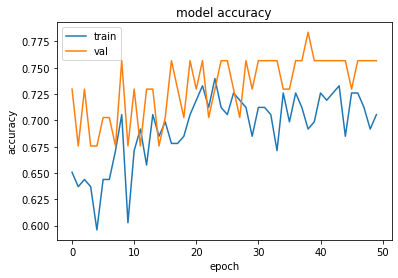

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

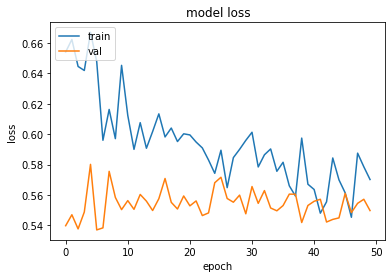

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test data

In [26]:
#prepare testing data
test = convert_sex_to_binary(convert_embarked_to_binary(test))

test = term_frequency_count(test, 'Ticket')

test = term_frequency_count(test, 'Cabin')

test = test.drop(columns=['Name', 'PassengerId'])

print(test.head())

    Pclass  Sex   Age  SibSp  Parch    Ticket      Fare     Cabin  Embarked  \
12       1    2  23.0      1      0  0.166667   82.2667  0.166667         2   
14       1    2  47.0      1      0  0.083333   61.1750  0.083333         2   
24       1    2  48.0      1      3  0.333333  262.3750  0.250000         1   
26       1    2  22.0      0      1  0.083333   61.9792  0.083333         1   
28       1    1  41.0      0      0  0.083333   30.5000  0.083333         2   

    Survived  
12         1  
14         1  
24         1  
26         1  
28         0  


In [27]:
#testing data

final_test(model, test)

3/3 [==============================] - 0s 4ms/step - loss: 0.7055 - accuracy: 0.5517
Loss =  0.7054560780525208
Accuracy =  0.5517241358757019


SVM

In [ ]:
clf = svm.SVC(kernel='poly', gamma = 3)

x_train, y_train = data[['Pclass','Sex', 'Age', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked']], data[['Survived']]

model = build_model(x_train)

history = clf.fit(x_train,y_train)
x_test, y_test = data[['Pclass','Sex', 'Age', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked']], data[['Survived']]

history = clf.predict(x_test)

print(history)

loss_and_metrics = model.predict(x_test)
#print('Degree:', deg)
print(loss_and_metrics)
#print('Loss = ',loss_and_metrics[0])
#print('Accuracy = ',loss_and_metrics[1])


In [40]:
  clf = svm.SVC(kernel='linear')

  x_train, y_train = data[['Pclass','Sex', 'Age', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked']], data[['Survived']]

  model = build_model(x_train)

  history = clf.fit(x_train,y_train)
  
  print(clf)

  x_test, y_test = data[['Pclass','Sex', 'Age', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked']], data[['Survived']]

  model.predict(x_test, verbose = 1)

  loss_and_metrics = model.evaluate(x_test, y_test)
  print('Loss = ',loss_and_metrics[0])
  print('Accuracy = ',loss_and_metrics[1])


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')
6/6 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.6721
Loss =  0.6562677621841431
Accuracy =  0.6721311211585999
